In [1]:
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time

np.random.seed(25)
tf.set_random_seed(25)
np.set_printoptions(suppress=True)

In [3]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [4]:
def variable_summaries(var):
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)
    
def weight(shape):
    w = tf.Variable(tf.truncated_normal(shape, stddev=0.1), name="W")
    variable_summaries(w)
    return w
def bias(shape):
    b = tf.Variable(tf.constant(0.1, shape=shape), name="b")
    variable_summaries(b)
    return b
def conv2d(x, W):
    c = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding="SAME")
    variable_summaries(c)
    return c
def max_pool_2x2(x):
    p = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    variable_summaries(p)
    return p

In [5]:
with tf.name_scope("Input_Layer"):
    x = tf.placeholder("float", shape=[None, 28*28], name="x")
    x_image = tf.reshape(x, [-1, 28, 28, 1])

with tf.name_scope("C1_Conv"):
    filter_num = 16
    W1 = weight([5,5,1,filter_num])
    b1 = bias([filter_num])
    Conv1 = conv2d(x_image, W1) + b1
    tf.summary.histogram("C1_pre_activation", Conv1)
    C1_Conv = tf.nn.relu(Conv1)
    tf.summary.histogram("C1_post_activation", C1_Conv)
    
with tf.name_scope("C1_Pool"):
    C1_Pool = max_pool_2x2(C1_Conv)
    
with tf.name_scope("C2_Conv"):
    filter_num = 36
    W2 = weight([5,5,16,36])
    b2 = bias([filter_num])
    Conv2 = conv2d(C1_Pool, W2) + b2
    tf.summary.histogram("C2_pre_activation", Conv2)
    C2_Conv = tf.nn.relu(Conv2)
    tf.summary.histogram("C2_post_activation", C2_Conv)
    
with tf.name_scope("C2_Pool"):
    C2_Pool = max_pool_2x2(C2_Conv)
    
with tf.name_scope("D_Flat"):
    # Flattern layer
    D_Flat = tf.reshape(C2_Pool, [-1, 1764])
    
with tf.name_scope("D_Hidden_Layer"):
    ## NN Hidden layer
    W3 = weight([1764, 128])
    b3 = bias([128])
    D_Hidden = tf.nn.relu(tf.matmul(D_Flat, W3)+b3)
    D_Hidden_Dropout = tf.nn.dropout(D_Hidden, keep_prob=0.8)
    
with tf.name_scope("Output_Layer"):
    # Ouutput layer
    W4 = weight([128, 10])
    b4 = bias([10])
    y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout, W4) + b4)
    

In [6]:
with tf.name_scope("optimizer"):
    y_label = tf.placeholder("float", shape=[None, 10], name="y_label")
    loss_function = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label)
                    )
    
    # global_step is a tensor variable here, it cannot be trained. This variable will be increased by one in each training step.
    # This variable will be used to calculate the learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # We use Adative Learning Rate technique here. The learning rate will be reduced for each 500 steps exponentially
    learning_rate = tf.train.exponential_decay(0.001, global_step,
                                           500, 0.96, staircase=False)
    with tf.name_scope("learning_rate"):
        # log the learning rate value for the tensorboard
        tf.summary.scalar("learning_rate", learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_function, global_step=global_step)

with tf.name_scope("evaluate_model"):
    correct_prediction = tf.equal(tf.argmax(y_predict, 1), tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
with tf.name_scope('loss_accuracy'):
    # log the loss and accuracy values for the tensorboard
    tf.summary.scalar("loss", loss_function)
    tf.summary.scalar("accuracy", accuracy)


In [7]:
epochs = 30
batchSize = 100
totalBatchs = int(mnist.train.num_examples/batchSize)
epoch_list = []
accuracy_list = []
loss_list = []

startTime = time()

merged = tf.summary.merge_all()

print("Start training ...")

with tf.Session() as sess:
    # Write logs and display on Tensorboard
    # the log will be saved in log/CNN folder, you can use `tensorboard --logdir log/CNN` to monitor the training progress
    train_writer = tf.summary.FileWriter('log/CNN', sess.graph)

    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for i in range(totalBatchs):
            batch_x, batch_y = mnist.train.next_batch(batchSize)
            sess.run(optimizer, feed_dict={x: batch_x, y_label: batch_y})

        summary, loss, acc = sess.run([merged, loss_function, accuracy], feed_dict={x: mnist.validation.images, y_label:mnist.validation.labels})

        # log the summaries for tensorboard
        train_writer.add_summary(summary, epoch)

        epoch_list.append(epoch)
        loss_list.append(loss)
        accuracy_list.append(acc)
        print("epoch:", "%02d" % (epoch+1), "Learning rate =", sess.run(learning_rate), "Loss =", "{:9f}".format(loss), " Accuracy =", acc)
    duration = time() - startTime
    print("Training takes:", duration, " seconds")
    
    
    summary, acc = sess.run([merged, accuracy], feed_dict={x: mnist.test.images, y_label: mnist.test.labels})
    print("Accuracy = {0}%".format(acc * 100))
    train_writer.add_summary(summary)
    prediction = sess.run(tf.argmax(y_predict, 1), feed_dict={x: mnist.test.images})
    print(prediction[:10])

Start training ...
epoch: 01 Learning rate = 0.000956089 Loss =  1.495722  Accuracy = 0.9694
epoch: 02 Learning rate = 0.000914106 Loss =  1.486634  Accuracy = 0.9762
epoch: 03 Learning rate = 0.000873967 Loss =  1.481103  Accuracy = 0.9816
epoch: 04 Learning rate = 0.00083559 Loss =  1.478611  Accuracy = 0.9828
epoch: 05 Learning rate = 0.000798899 Loss =  1.477876  Accuracy = 0.9838
epoch: 06 Learning rate = 0.000763818 Loss =  1.475015  Accuracy = 0.9864
epoch: 07 Learning rate = 0.000730278 Loss =  1.475258  Accuracy = 0.9864
epoch: 08 Learning rate = 0.000698211 Loss =  1.474325  Accuracy = 0.987
epoch: 09 Learning rate = 0.000667552 Loss =  1.473866  Accuracy = 0.987
epoch: 10 Learning rate = 0.000638239 Loss =  1.473991  Accuracy = 0.9872
epoch: 11 Learning rate = 0.000610213 Loss =  1.472391  Accuracy = 0.9894
epoch: 12 Learning rate = 0.000583418 Loss =  1.473101  Accuracy = 0.989
epoch: 13 Learning rate = 0.0005578 Loss =  1.471348  Accuracy = 0.9902
epoch: 14 Learning rate =

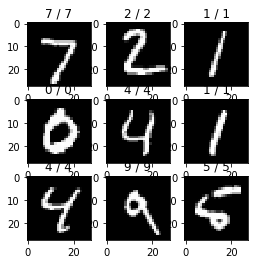

In [8]:
plt.figure(figsize=(4,4))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    img = mnist.test.images[i].reshape([28,28])
    plt.imshow(img, cmap="gray")
    l = np.argmax(mnist.test.labels[i])
    plt.title("%s / %s" % (l, prediction[i]))
